TP1 - Recalage d'images
=============

In [1]:
import numpy as np
import numpy.linalg as npl
from scipy import signal
from scipy import interpolate
from PIL import Image
import matplotlib.pyplot as plt

Un problème fréquemment rencontré dans le domaine du traitement d’images est celui du recalage. On dispose de plusieurs images prises à des temps différents, ou par des appareils différents, et on aimerait les mettre en correspondence, c’est-à-dire trouver une déformation du plan, qui assure une correspondence point à point des objets sous-jacents. Donnons quelques exemples d’applications :
* Traitements/retouches d’images. Par exemple, on peut vouloir construire un panoramique à partir d’images de petite taille. Il faut les recaler préalablement.
* Evaluation des déplacements d’objets dans des séquences vidéos (e.g. trouver un défaut de fonctionnement d’un organe, caméras de surveillance, design de robots intelligents ou de systèmes de navigation automatiques ...)
* Couplage d’informations. Par exemple, en imagerie médicale, on obtient une information plus riche en utilisant à la fois une radio et une angiographie. L’une apporte des informations structurelles, l’autre des informations fonctionnelles. Le couplage des deux images donne plus d’information au praticien.
* Beaucoup d’autres applications...

Dans ce TP, nous allons proposer un modèle de recalage assez élémentaire. Les idées constitutives se retrouvent cependant dans presque toutes les techniques récentes.

In [2]:
def get_images():
    band1 = np.loadtxt("band1.txt")
    band2 = np.loadtxt("band2.txt")
    return band1, band2
f,g = get_images()

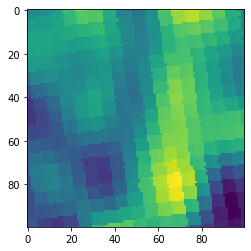

In [3]:
plt.imshow(f[1000:1100,500:600])
im1 = f[1000:1100,500:600]

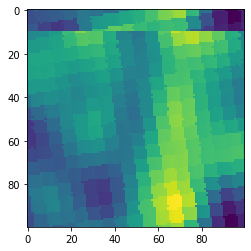

In [5]:
plt.imshow(np.roll(f[1000:1100,500:600],10,axis=0))
im2 = np.roll(f[1000:1100,500:600],10,axis=0)

In [15]:
def interpol(f,ux,uy) :
    # function that computes f \circ Id+u and interpolates it on a mesh
    nx,ny=f.shape
    ip=interpolate.RectBivariateSpline(np.arange(nx),np.arange(ny),f)
    [X,Y]=np.meshgrid(np.arange(nx),np.arange(ny), indexing='ij')
    X=X+ux
    Y=Y+uy
    return np.reshape(ip.ev(X.ravel(),Y.ravel()),(nx,ny))

def dx(im) :
    d=np.zeros(im.shape)
    d[:-1,:]=im[1:,:]-im[:-1,:]
    return d #retourne dx*im
def dy(im) :
    d=np.zeros(im.shape)
    d[:,:-1]=im[:,1:]-im[:,:-1]
    return d
def dxT(im) :
    d=np.zeros(im.shape)
    d[0,:] = -im[0,:]
    d[1:-1,:] = im[:-2,:] - im[1:-1:,:]
    d[-1,:] = im[-2,:]
    return d  
def dyT(im) :
    d=np.zeros(im.shape)
    d[:,0] = -im[:,0]
    d[:,1:-1] = im[:,:-2] - im[:,1:-1]
    d[:,-1] = im[:,-2]    
    return d

def objective_function(f,g,ux,uy,lamb,mu) :
    fu=interpol(f,ux,uy)
    R = mu/2*npl.norm(dx(uy)+dy(ux))**2 + ((lamb+mu)/2)*npl.norm(dx(ux) + dy(uy))**2
    E = 1/2*npl.norm(fu  - g)**2
    obj = E + R
    return obj,fu

def linesearch(ux,uy,step,descentx,descenty,obj_old,f,g,lamb,mu) :
    step=2*step
    tmpx=ux-step*descentx
    tmpy=uy-step*descenty
    obj,fu=objective_function(f,g,tmpx,tmpy,lamb,mu)
    while obj >obj_old and step > 1.e-8:
        step=0.5*step
        tmpx=ux-step*descentx
        tmpy=uy-step*descenty
        obj,fu=objective_function(f,g,tmpx,tmpy,lamb,mu)
    return tmpx,tmpy,step

def RecalageDG(f,g,lamb,mu,nitermax,stepini) : 
    ux=np.zeros(f.shape)
    uy=np.zeros(f.shape)  
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj)   

        gradEx = (fu - g)*interpol(dx(f),ux,uy)
        gradEy = (fu - g)*interpol(dy(f),ux,uy)
        gradE = np.array([gradEx, gradEy])
        
        
        # Gradient of R at point u
        gradRx = mu*(dyT(dy(ux)) + dyT(dx(uy))) + (lamb+mu)*(dxT(dx(ux)) + (dxT(dy(uy))))
        gradRy = mu * (dxT(dy(ux)) + dxT(dx(uy))) + (lamb + mu)*(dyT(dx(ux)) + dyT(dy(uy)))
        
        
        # Gradient of E+R at point u
        gradx = gradEx + gradRx
        grady = gradEy + gradRy
        
        
        ux,uy,step=linesearch(ux,uy,step,gradx,grady,obj,f,g,lamb,mu)
        step_list.append(step)
        if (niter % 3 ==0) :
            print('iteration :',niter,' cost function :',obj,'step :',step)
    return ux,uy,np.array(CF),np.array(step_list),niter

#df déjà interpolé
def JPsi(vx,vy,df,lamb,mu) :
    JPsi0 = df[0]*vx+df[1]*vy
    JPsi1 = np.sqrt(mu)*dy(vx)+np.sqrt(mu)*dx(vy)
    JPsi2 = np.sqrt(mu+lamb)*dx(vx)+ np.sqrt(mu+lamb)*dy(vy)
    
    return [JPsi0,JPsi1,JPsi2]

def JTPsi(phi,df,lamb,mu) :
    ux =df[0]*phi[0]+ np.sqrt(mu)*dyT(phi[1])+ np.sqrt(mu+lamb)*dxT(phi[2])
    uy =df[1]*phi[0]+ np.sqrt(mu)*dxT(phi[1])+ np.sqrt(mu+lamb)*dyT(phi[2])

    return [ux,uy]

def JTJ(vx,vy,df,lamb,mu,epsilon) :
    J = JPsi(vx,vy,df,lamb,mu)
    JJ = JTPsi(J,df,lamb,mu)
    #JJ += epsilon*vx + epsilon*vy
    uxs = JJ[0]+epsilon*vx
    uys = JJ[1]+epsilon*vy
    
    return uxs,uys

def CGSolve(u0x,u0y,lamb,mu,b,epsilon,df) :
    nitmax=100;
    ux=u0x; uy=u0y; #point de départ de l'algorithme
    # Computes JTJu
    Ax,Ay=JTJ(ux,uy,df,lamb,mu,epsilon);
    rx=b[0]-Ax
    ry=b[1]-Ay
    px=rx
    py=ry
    rsold=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
    for i in range(nitmax) :
        Apx,Apy=JTJ(px,py,df,lamb,mu,epsilon);
        alpha=rsold/(np.vdot(rx[:],Apx[:])+np.vdot(ry[:],Apy[:]))
        ux=ux+alpha*px
        uy=uy+alpha*py
        rx=rx-alpha*Apx
        ry=ry-alpha*Apy
        rsnew=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
        if np.sqrt(rsnew)<1e-10 :
            return [ux,uy]
        px=rx+rsnew/rsold*px
        py=ry+rsnew/rsold*py
        rsold=rsnew
    return [ux,uy]

def RecalageGN(f,g,lamb,mu,nitermax,stepini,epsi) : 
    ux=np.zeros(f.shape)
    uy=np.zeros(f.shape)  
    descentx=np.zeros(f.shape)
    descenty=np.zeros(f.shape)
    
   
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    dfx=dx(f)
    dfy=dy(f)
    df = [dfx,dfy]
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj)
        # Gradient of F at point u
        dfu=[interpol(dfx,ux,uy),interpol(dfy,ux,uy)] ##on dérive puis on interpole
        phi = [fu - g,np.sqrt(mu)*(dx(uy) + dy(ux)), np.sqrt(mu + lamb)*(dx(ux) + dy(uy))]
        b = JTPsi(phi,dfu,lamb,mu)
        [descentx,descenty]=CGSolve(descentx,descenty,lamb,mu,b,epsi,dfu)
        ux,uy,step=linesearch(ux,uy,step,descentx,descenty,obj,f,g,lamb,mu)
        step_list.append(step)
        # Display
        if (niter % 3 ==0) :
            print('iteration :',niter,' cost function :',obj,'step :',step)
    return ux,uy,np.array(CF),np.array(step_list),niter

In [11]:
lamb = np.linspace(-1,1.5,10)
mu = np.copy(0.1*lamb)
nitertab = np.zeros(10)
nitermax=3000
f,g=get_images()
step0 = 0.01
for i in range(10):
    ux,uy,CF,step,nitertab[i]=RecalageDG(f,g,lamb[i],mu[i],nitermax,step0)

KeyboardInterrupt: 

0.11111111111111116


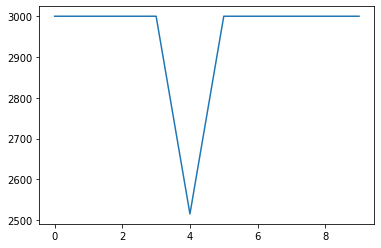

In [10]:
plt.plot(nitertab)
k = np.argmin(nitertab)
print(lamb[k])

In [28]:
k = 0.11
lamb0 = 0.11
mu = 0.1*lamb0
nitermax=3000
step0 = 0.01
ux,uy,CF,step,niter=RecalageDG(im1,im2,lamb0,mu,nitermax,step0)

iteration : 3  cost function : 80.51123776123845 step : 0.08
iteration : 6  cost function : 80.40180962749857 step : 0.64
iteration : 9  cost function : 79.84652172171097 step : 5.12
iteration : 12  cost function : 78.72598048711015 step : 2.56
iteration : 15  cost function : 78.5054947584329 step : 1.28
iteration : 18  cost function : 78.27150318449391 step : 1.28
iteration : 21  cost function : 78.02166236965697 step : 1.28
iteration : 24  cost function : 77.81155886669066 step : 1.28
iteration : 27  cost function : 77.58308728518236 step : 1.28
iteration : 30  cost function : 77.37504346993923 step : 2.56
iteration : 33  cost function : 77.15411612577407 step : 1.28
iteration : 36  cost function : 76.97135285700453 step : 1.28
iteration : 39  cost function : 76.79845605395136 step : 1.28
iteration : 42  cost function : 76.63732104953802 step : 1.28
iteration : 45  cost function : 76.47043259895965 step : 1.28
iteration : 48  cost function : 76.31136455181664 step : 1.28
iteration : 

iteration : 405  cost function : 67.32732950511055 step : 2.56
iteration : 408  cost function : 67.27402885424108 step : 2.56
iteration : 411  cost function : 67.22680518852238 step : 2.56
iteration : 414  cost function : 67.17195214574816 step : 2.56
iteration : 417  cost function : 67.12652535646973 step : 2.56
iteration : 420  cost function : 67.07463338372906 step : 1.28
iteration : 423  cost function : 67.03270002077772 step : 2.56
iteration : 426  cost function : 66.98335968090855 step : 1.28
iteration : 429  cost function : 66.94447163186258 step : 1.28
iteration : 432  cost function : 66.89729145753873 step : 1.28
iteration : 435  cost function : 66.86148441735835 step : 1.28
iteration : 438  cost function : 66.81599142172404 step : 1.28
iteration : 441  cost function : 66.76487899797694 step : 2.56
iteration : 444  cost function : 66.7380103955846 step : 1.28
iteration : 447  cost function : 66.6800805759952 step : 2.56
iteration : 450  cost function : 66.63594784339021 step :

iteration : 801  cost function : 61.00262302638858 step : 1.28
iteration : 804  cost function : 60.96465709076951 step : 1.28
iteration : 807  cost function : 60.91613071877299 step : 2.56
iteration : 810  cost function : 60.880262373028444 step : 2.56
iteration : 813  cost function : 60.84623785895736 step : 2.56
iteration : 816  cost function : 60.81323881074747 step : 2.56
iteration : 819  cost function : 60.781578402869584 step : 2.56
iteration : 822  cost function : 60.75003621796777 step : 2.56
iteration : 825  cost function : 60.7191217263482 step : 2.56
iteration : 828  cost function : 60.68760815868021 step : 2.56
iteration : 831  cost function : 60.656850358505125 step : 2.56
iteration : 834  cost function : 60.62535436550525 step : 2.56
iteration : 837  cost function : 60.59491511597474 step : 2.56
iteration : 840  cost function : 60.56384043395609 step : 2.56
iteration : 843  cost function : 60.53412175196175 step : 2.56
iteration : 846  cost function : 60.50356492793744 st

iteration : 1197  cost function : 57.49735340683298 step : 2.56
iteration : 1200  cost function : 57.47843432675214 step : 2.56
iteration : 1203  cost function : 57.45841743879797 step : 2.56
iteration : 1206  cost function : 57.43977836406438 step : 2.56
iteration : 1209  cost function : 57.41958593311165 step : 2.56
iteration : 1212  cost function : 57.40095201566167 step : 2.56
iteration : 1215  cost function : 57.38041236758195 step : 2.56
iteration : 1218  cost function : 57.361656131514856 step : 2.56
iteration : 1221  cost function : 57.34061029568982 step : 2.56
iteration : 1224  cost function : 57.32162487140228 step : 2.56
iteration : 1227  cost function : 57.30013330878299 step : 1.28
iteration : 1230  cost function : 57.28103895136199 step : 2.56
iteration : 1233  cost function : 57.25927658936146 step : 1.28
iteration : 1236  cost function : 57.2402707227908 step : 1.28
iteration : 1239  cost function : 57.218598405620654 step : 1.28
iteration : 1242  cost function : 57.19

iteration : 1590  cost function : 55.40126150594229 step : 2.56
iteration : 1593  cost function : 55.38514608998304 step : 2.56
iteration : 1596  cost function : 55.367527419069454 step : 2.56
iteration : 1599  cost function : 55.351612150053896 step : 2.56
iteration : 1602  cost function : 55.334020684979386 step : 1.28
iteration : 1605  cost function : 55.318415660345174 step : 1.28
iteration : 1608  cost function : 55.30094120195273 step : 1.28
iteration : 1611  cost function : 55.2857384948106 step : 1.28
iteration : 1614  cost function : 55.26846987536027 step : 1.28
iteration : 1617  cost function : 55.25380252052415 step : 1.28
iteration : 1620  cost function : 55.23686586020823 step : 1.28
iteration : 1623  cost function : 55.21544838097446 step : 2.56
iteration : 1626  cost function : 55.19849020870666 step : 2.56
iteration : 1629  cost function : 55.1822630296051 step : 2.56
iteration : 1632  cost function : 55.16550747274573 step : 2.56
iteration : 1635  cost function : 55.1

iteration : 1983  cost function : 53.9015251963973 step : 1.28
iteration : 1986  cost function : 53.894052730832804 step : 1.28
iteration : 1989  cost function : 53.88640127278037 step : 1.28
iteration : 1992  cost function : 53.878194021526824 step : 1.28
iteration : 1995  cost function : 53.87006721318836 step : 1.28
iteration : 1998  cost function : 53.86166791267403 step : 1.28
iteration : 2001  cost function : 53.85365810205967 step : 1.28
iteration : 2004  cost function : 53.84178977970488 step : 2.56
iteration : 2007  cost function : 53.833264849711256 step : 2.56
iteration : 2010  cost function : 53.824848591191326 step : 2.56
iteration : 2013  cost function : 53.81669150256658 step : 2.56
iteration : 2016  cost function : 53.80863654394349 step : 2.56
iteration : 2019  cost function : 53.800848449206896 step : 2.56
iteration : 2022  cost function : 53.79314554279911 step : 2.56
iteration : 2025  cost function : 53.785719739317884 step : 2.56
iteration : 2028  cost function : 5

iteration : 2376  cost function : 52.858618409957 step : 2.56
iteration : 2379  cost function : 52.84783673860679 step : 2.56
iteration : 2382  cost function : 52.83697603276071 step : 2.56
iteration : 2385  cost function : 52.82587550302382 step : 2.56
iteration : 2388  cost function : 52.814743445929466 step : 2.56
iteration : 2391  cost function : 52.80358779532405 step : 2.56
iteration : 2394  cost function : 52.79269988732937 step : 2.56
iteration : 2397  cost function : 52.78206843263332 step : 2.56
iteration : 2400  cost function : 52.77185528501544 step : 2.56
iteration : 2403  cost function : 52.76192178615335 step : 2.56
iteration : 2406  cost function : 52.75231575112629 step : 2.56
iteration : 2409  cost function : 52.74291480728033 step : 2.56
iteration : 2412  cost function : 52.733765056587664 step : 2.56
iteration : 2415  cost function : 52.72475439825379 step : 2.56
iteration : 2418  cost function : 52.71593642360115 step : 2.56
iteration : 2421  cost function : 52.707

iteration : 2769  cost function : 51.56485612682459 step : 1.28
iteration : 2772  cost function : 51.551449274057724 step : 2.56
iteration : 2775  cost function : 51.543526752638165 step : 1.28
iteration : 2778  cost function : 51.52923615602708 step : 2.56
iteration : 2781  cost function : 51.518155826405255 step : 2.56
iteration : 2784  cost function : 51.507904454370085 step : 2.56
iteration : 2787  cost function : 51.49730149914636 step : 2.56
iteration : 2790  cost function : 51.4876424394964 step : 2.56
iteration : 2793  cost function : 51.477552507032854 step : 2.56
iteration : 2796  cost function : 51.468480894396855 step : 2.56
iteration : 2799  cost function : 51.45885094066623 step : 2.56
iteration : 2802  cost function : 51.45027971217602 step : 2.56
iteration : 2805  cost function : 51.440992824104654 step : 2.56
iteration : 2808  cost function : 51.43282927575568 step : 2.56
iteration : 2811  cost function : 51.423784133874044 step : 2.56
iteration : 2814  cost function :

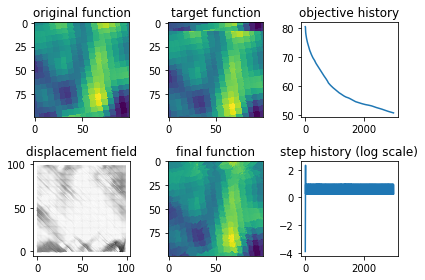

In [29]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(im1)
ax[0,0].set_title('original function')
ax[0,1].imshow(im2)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(im1,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

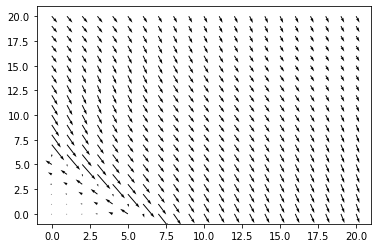

In [0]:
plt.quiver(ux, uy)
plt.show()

In [20]:
#df déjà interpolé
def JPsi(vx,vy,df,lamb,mu) :
    JPsi0 = df[0]*vx+df[1]*vy
    JPsi1 = np.sqrt(mu)*dy(vx)+np.sqrt(mu)*dx(vy)
    JPsi2 = np.sqrt(mu+lamb)*dx(vx)+ np.sqrt(mu+lamb)*dy(vy)
    
    return [JPsi0,JPsi1,JPsi2]

def JTPsi(phi,df,lamb,mu) :
    ux =df[0]*phi[0]+ np.sqrt(mu)*dyT(phi[1])+ np.sqrt(mu+lamb)*dxT(phi[2])
    uy =df[1]*phi[0]+ np.sqrt(mu)*dxT(phi[1])+ np.sqrt(mu+lamb)*dyT(phi[2])

    return [ux,uy]

def JTJ(vx,vy,df,lamb,mu,epsilon) :
    J = JPsi(vx,vy,df,lamb,mu)
    JJ = JTPsi(J,df,lamb,mu)
    #JJ += epsilon*vx + epsilon*vy
    uxs = JJ[0]+epsilon*vx
    uys = JJ[1]+epsilon*vy
    
    return uxs,uys

In [21]:
 def CGSolve(u0x,u0y,lamb,mu,b,epsilon,df) :
    nitmax=100;
    ux=u0x; uy=u0y; #point de départ de l'algorithme
    # Computes JTJu
    Ax,Ay=JTJ(ux,uy,df,lamb,mu,epsilon);
    rx=b[0]-Ax
    ry=b[1]-Ay
    px=rx
    py=ry
    rsold=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
    for i in range(nitmax) :
        Apx,Apy=JTJ(px,py,df,lamb,mu,epsilon);
        alpha=rsold/(np.vdot(rx[:],Apx[:])+np.vdot(ry[:],Apy[:]))
        ux=ux+alpha*px
        uy=uy+alpha*py
        rx=rx-alpha*Apx
        ry=ry-alpha*Apy
        rsnew=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
        if np.sqrt(rsnew)<1e-10 :
            return [ux,uy]
        px=rx+rsnew/rsold*px
        py=ry+rsnew/rsold*py
        rsold=rsnew
    return [ux,uy]

Q8. Compléter l'algorithme RecalageGN implémentant la méthode de Levenberg-Marquardt.

In [22]:
def RecalageGN_clean(f,g,lamb,mu,nitermax,stepini,epsi) : 
    ux=np.zeros(f.shape)
    uy=np.zeros(f.shape)  
    descentx=np.zeros(f.shape)
    descenty=np.zeros(f.shape)  
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj)
        # Gradient of F at point u
        raise ValueError('Compute b here')
        raise ValueError('Compute dfx,dfy here')    
        [descentx,descenty]=CGSolve(descentx,descenty,lamb,mu,b,epsi,dfx,dfy)
        ux,uy,step=linesearch(ux,uy,step,descentx,descenty,obj,f,g,lamb,mu)
        step_list.append(step)
        # Display
        if (niter % 3 ==0) :
            print('iteration :',niter,' cost function :',obj,'step :',step)
    return ux,uy,np.array(CF),np.array(step_list)

In [23]:
def RecalageGN(f,g,lamb,mu,nitermax,stepini,epsi) : 
    ux=np.zeros(f.shape)
    uy=np.zeros(f.shape)  
    descentx=np.zeros(f.shape)
    descenty=np.zeros(f.shape)
    
   
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    dfx=dx(f)
    dfy=dy(f)
    df = [dfx,dfy]
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj)
        # Gradient of F at point u
        dfu=[interpol(dfx,ux,uy),interpol(dfy,ux,uy)] ##on dérive puis on interpole
        phi = [fu - g,np.sqrt(mu)*(dx(uy) + dy(ux)), np.sqrt(mu + lamb)*(dx(ux) + dy(uy))]
        b = JTPsi(phi,dfu,lamb,mu)
        [descentx,descenty]=CGSolve(descentx,descenty,lamb,mu,b,epsi,dfu)
        ux,uy,step=linesearch(ux,uy,step,descentx,descenty,obj,f,g,lamb,mu)
        step_list.append(step)
        # Display
        if (niter % 3 ==0) :
            print('iteration :',niter,' cost function :',obj,'step :',step)
    return ux,uy,np.array(CF),np.array(step_list),niter

In [18]:
lambk = np.linspace(0,50,20)
muk = np.copy(lambk)
niter1 = np.zeros(20)
step1=0.01
eps1=0.1
nitermax=3000

for i in range(20) :
    ux,uy,CF,step,niter1[i]=RecalageGN(f,g,lambk[i],muk[i],nitermax,step1,eps1)

iteration : 3  cost function : 18.73324891787389 step : 0.08
iteration : 6  cost function : 15.390488694830223 step : 0.64
iteration : 9  cost function : 3.581852271528055 step : 5.12
iteration : 12  cost function : 1.626269749864145 step : 5.12
iteration : 15  cost function : 1.2910693123507282 step : 10.24
iteration : 18  cost function : 1.2220570540253017 step : 5.12
iteration : 21  cost function : 1.156019983316257 step : 10.24
iteration : 24  cost function : 1.129399108665922 step : 10.24
iteration : 27  cost function : 1.1108166754201185 step : 10.24
iteration : 30  cost function : 1.0962568942912683 step : 10.24
iteration : 33  cost function : 1.0864950351597416 step : 5.12
iteration : 36  cost function : 1.0730801953354117 step : 5.12
iteration : 39  cost function : 1.063532865099978 step : 5.12
iteration : 42  cost function : 1.0552463888102417 step : 10.24
iteration : 45  cost function : 1.0503228786972088 step : 10.24
iteration : 48  cost function : 1.046099117142508 step : 

Q9. Tester le nouvel algorithme et comparer sa vitesse de convergence avec celle de l'algorithme de gradient.

In [24]:
epsi=0.1
nitermax=1000
lamb = 10.5
mu = lamb
step0=0.01
ux,uy,CF,step=RecalageGN(im1,im2,lamb,mu,nitermax,step0,epsi)

iteration : 3  cost function : 351.0509882895292 step : 0.08
iteration : 6  cost function : 349.83283546918807 step : 0.64
iteration : 9  cost function : 342.81823436203774 step : 5.12
iteration : 12  cost function : 327.03355473953496 step : 1.28
iteration : 15  cost function : 321.4833717428593 step : 2.56
iteration : 18  cost function : 317.43173575374425 step : 2.56
iteration : 21  cost function : 314.11884776353816 step : 2.56
iteration : 24  cost function : 311.3387616309926 step : 2.56
iteration : 27  cost function : 309.2553960803599 step : 1.28
iteration : 30  cost function : 306.80782665617244 step : 2.56
iteration : 33  cost function : 304.81399479488505 step : 2.56
iteration : 36  cost function : 303.1441175398639 step : 2.56
iteration : 39  cost function : 302.2245748562168 step : 1.28
iteration : 42  cost function : 300.4378992405051 step : 1.28
iteration : 45  cost function : 298.9775844837772 step : 2.56
iteration : 48  cost function : 297.7224796703974 step : 2.56
iter

iteration : 393  cost function : 196.07676263912268 step : 2.56
iteration : 396  cost function : 195.61132331489787 step : 1.28
iteration : 399  cost function : 194.94978333794882 step : 2.56
iteration : 402  cost function : 194.35701914047516 step : 2.56
iteration : 405  cost function : 193.80306970749885 step : 2.56
iteration : 408  cost function : 193.44889599365527 step : 1.28
iteration : 411  cost function : 192.77871313891123 step : 2.56
iteration : 414  cost function : 192.20048996091666 step : 2.56
iteration : 417  cost function : 191.6711827522857 step : 2.56
iteration : 420  cost function : 191.16702913929433 step : 2.56
iteration : 423  cost function : 190.76477608201822 step : 1.28
iteration : 426  cost function : 190.1965573537389 step : 2.56
iteration : 429  cost function : 189.69394217686386 step : 2.56
iteration : 432  cost function : 189.22327218427665 step : 2.56
iteration : 435  cost function : 188.92845649089352 step : 1.28
iteration : 438  cost function : 188.36167

iteration : 780  cost function : 158.33192503373658 step : 2.56
iteration : 783  cost function : 158.18416906050808 step : 1.28
iteration : 786  cost function : 157.95824316976223 step : 2.56
iteration : 789  cost function : 157.76323583414188 step : 2.56
iteration : 792  cost function : 157.58662909515738 step : 2.56
iteration : 795  cost function : 157.42176373852652 step : 2.56
iteration : 798  cost function : 157.28811544229086 step : 1.28
iteration : 801  cost function : 157.11368703008492 step : 2.56
iteration : 804  cost function : 156.96205536716747 step : 2.56
iteration : 807  cost function : 156.82364113761076 step : 2.56
iteration : 810  cost function : 156.74247181872505 step : 1.28
iteration : 813  cost function : 156.58296936145385 step : 1.28
iteration : 816  cost function : 156.45140847677575 step : 2.56
iteration : 819  cost function : 156.33466207640643 step : 2.56
iteration : 822  cost function : 156.22785618263114 step : 2.56
iteration : 825  cost function : 156.154

ValueError: too many values to unpack (expected 4)

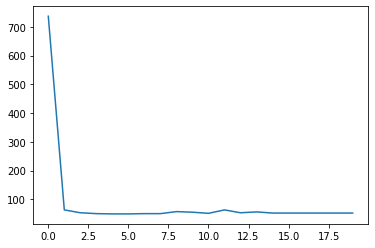

In [19]:
plt.plot(niter1)

In [20]:
k = np.argmin(niter1)
print(lambk[k])

10.526315789473685


In [22]:
lamb = lambk[k]
mu = lamb
epsi=0.1
nitermax= 3000
ux,uy,CF,step,n=RecalageGN(f,g,lamb,mu,nitermax,step0,epsi)

iteration : 3  cost function : 18.98095117068198 step : 0.08
iteration : 6  cost function : 17.781692275955496 step : 0.64
iteration : 9  cost function : 10.490672234542957 step : 5.12
iteration : 12  cost function : 1.2578977484710494 step : 2.56
iteration : 15  cost function : 0.8716511881737025 step : 1.28
iteration : 18  cost function : 0.5503139957305556 step : 1.28
iteration : 21  cost function : 0.39862148979148027 step : 2.56
iteration : 24  cost function : 0.32571411539882916 step : 2.56
iteration : 27  cost function : 0.2882741469654275 step : 2.56
iteration : 30  cost function : 0.2694139929169899 step : 2.56
iteration : 33  cost function : 0.25938879775848545 step : 2.56
iteration : 36  cost function : 0.254332998769122 step : 2.56
iteration : 39  cost function : 0.25167373091793044 step : 2.56
iteration : 42  cost function : 0.2504214625419756 step : 2.56
iteration : 45  cost function : 0.25006511041439294 step : 1.28
iteration : 48  cost function : 0.24962985346377883 ste

on prend lambda = 10,5

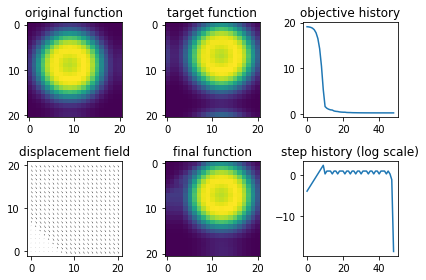

In [23]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

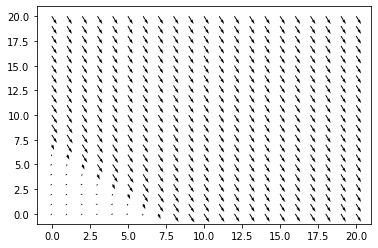

In [24]:
plt.quiver(ux, uy)
plt.show()

5. Jeu des différences
======================
Maintenant que vous avez implémenté et testé les deux algorithmes sur l'image-jouet proposée, voyons que cela donne sur une image IRM d'un cerveau. Saurez-vous détecter les différences/déplacements entre les deux images ?

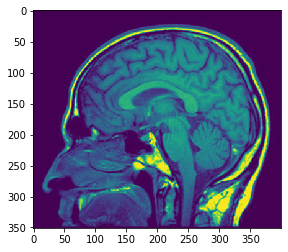

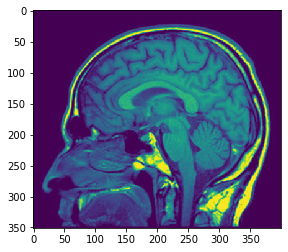

In [13]:
im1=Image.open('IRM1.png')
im2=Image.open("IRM2.png")
plt.imshow(plt.imread('IRM1.png'))
plt.show()
plt.imshow(plt.imread('IRM2.png'))
plt.show()

In [14]:
[n,m]=im1.size
sigma=0.1
[X,Y]=np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,m), indexing='xy')
Z=np.sqrt(X*X+Y*Y)
G=np.fft.fftshift(np.exp(-(X**2+Y**2)/sigma**2))
f=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im1)))
g=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im2))) 
f=f/np.max(f)
g=g/np.max(g)

In [ ]:
epsi=0.01
stepini=0.01
nitermax = 5000
lamb = 0.0001
mu = 0.0001
ux,uy,CF,step, niter=RecalageGN(f,g,lamb,mu,nitermax,stepini,epsi)

iteration : 3  cost function : 0.14378266568826878 step : 0.08
iteration : 6  cost function : 0.1435182966307982 step : 0.64
iteration : 9  cost function : 0.1414353121976472 step : 5.12
iteration : 12  cost function : 0.12664688791055412 step : 40.96
iteration : 15  cost function : 0.07367524667918667 step : 327.68
iteration : 18  cost function : 0.054490660858069626 step : 20.48
iteration : 21  cost function : 0.053399614583654234 step : 20.48
iteration : 24  cost function : 0.053030424409352475 step : 10.24
iteration : 27  cost function : 0.05275613354759687 step : 10.24
iteration : 30  cost function : 0.05251414487138783 step : 10.24
iteration : 33  cost function : 0.05236623483392294 step : 10.24
iteration : 36  cost function : 0.05203014453222114 step : 10.24
iteration : 39  cost function : 0.05190443513327623 step : 5.12
iteration : 42  cost function : 0.051618297422295525 step : 5.12
iteration : 45  cost function : 0.05136707555049709 step : 10.24
iteration : 48  cost function 

In [ ]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()